Using device: mps
----------------------------------------------------------------------------
Model: Skipgram            | Epoch   1/10  Loss:   15994.6325  Time:   1.43s
Model: Skipgram            | Epoch   2/10  Loss:   11390.5120  Time:   1.38s
Model: Skipgram            | Epoch   3/10  Loss:    9619.2259  Time:   1.58s
Model: Skipgram            | Epoch   4/10  Loss:    8467.6511  Time:   1.44s
Model: Skipgram            | Epoch   5/10  Loss:    7652.8952  Time:   1.39s
Model: Skipgram            | Epoch   6/10  Loss:    7099.6164  Time:   1.38s
Model: Skipgram            | Epoch   7/10  Loss:    6616.3143  Time:   1.37s
Model: Skipgram            | Epoch   8/10  Loss:    6280.9334  Time:   1.38s
Model: Skipgram            | Epoch   9/10  Loss:    6014.0718  Time:   1.84s
Model: Skipgram            | Epoch  10/10  Loss:    5779.0599  Time:   1.48s


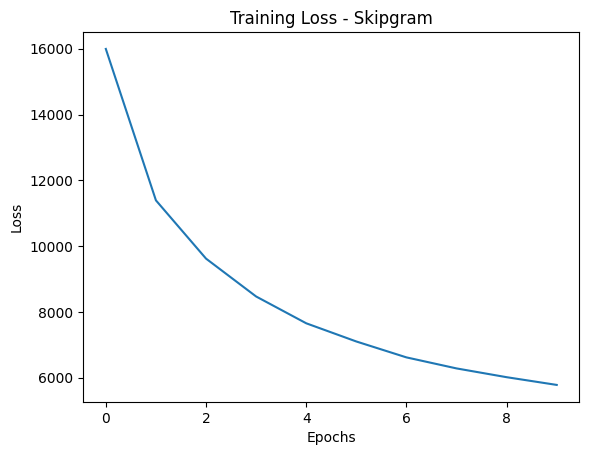

----------------------------------------------------------------------------
Model: SkipgramNegSampling | Epoch   1/10  Loss: 1099020.5228  Time:   2.04s
Model: SkipgramNegSampling | Epoch   2/10  Loss:  786440.8451  Time:   1.91s
Model: SkipgramNegSampling | Epoch   3/10  Loss:  611776.2791  Time:   2.51s
Model: SkipgramNegSampling | Epoch   4/10  Loss:  480232.8419  Time:   2.17s
Model: SkipgramNegSampling | Epoch   5/10  Loss:  376293.7209  Time:   1.88s
Model: SkipgramNegSampling | Epoch   6/10  Loss:  302599.5309  Time:   2.15s
Model: SkipgramNegSampling | Epoch   7/10  Loss:  246900.5605  Time:   1.84s
Model: SkipgramNegSampling | Epoch   8/10  Loss:  208337.7855  Time:   1.87s
Model: SkipgramNegSampling | Epoch   9/10  Loss:  180294.3591  Time:   2.01s
Model: SkipgramNegSampling | Epoch  10/10  Loss:  160336.1721  Time:   1.81s


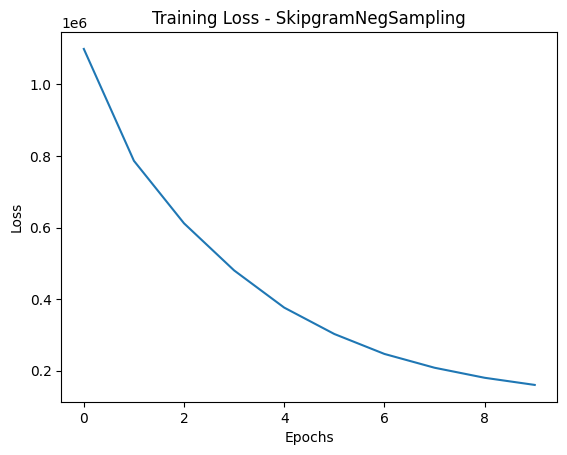

----------------------------------------------------------------------------
Model: GloVe               | Epoch   1/10  Loss:    1727.4490  Time:   0.60s
Model: GloVe               | Epoch   2/10  Loss:    1495.6849  Time:   0.68s
Model: GloVe               | Epoch   3/10  Loss:    1293.9021  Time:   0.66s
Model: GloVe               | Epoch   4/10  Loss:    1121.4021  Time:   0.82s
Model: GloVe               | Epoch   5/10  Loss:     971.4352  Time:   0.65s
Model: GloVe               | Epoch   6/10  Loss:     843.1984  Time:   0.57s
Model: GloVe               | Epoch   7/10  Loss:     732.1265  Time:   0.58s
Model: GloVe               | Epoch   8/10  Loss:     636.1056  Time:   0.57s
Model: GloVe               | Epoch   9/10  Loss:     552.4238  Time:   0.67s
Model: GloVe               | Epoch  10/10  Loss:     479.3130  Time:   0.67s


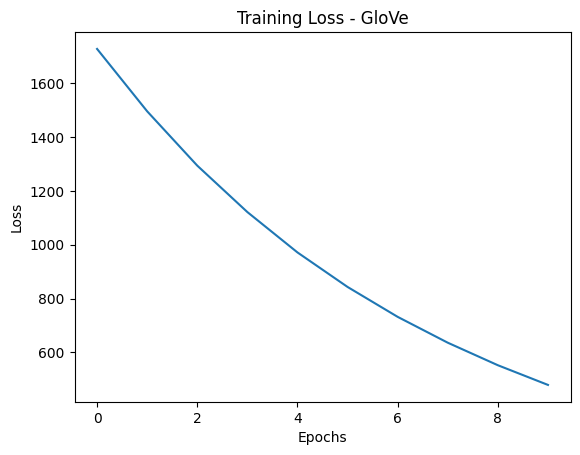

----------------------------------------------------------------------------
All models have been saved.


In [31]:
# Unified Model: Skipgram, Negative Sampling, and GloVe using Reuters Dataset

import random
import time
import math
from collections import Counter
import matplotlib.pyplot as plt


import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from nltk.corpus import reuters

# Device Configuration
device = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))
print(f"Using device: {device}")

# Download necessary NLTK datasets
# nltk.download("reuters")
# nltk.download("punkt")


# Build Reuters Corpus
def build_corpus(sample_size=100):
    corpus = []
    for file_id in reuters.fileids()[:sample_size]:
        words = [word.lower() for word in reuters.words(file_id) if word.isalpha()]
        corpus.append(words)
    return corpus


# Vocabulary Building
def build_vocab(corpus, min_freq=5):
    words = [word for sentence in corpus for word in sentence]
    word_counts = Counter(words)
    vocab = [word for word, count in word_counts.items() if count >= min_freq]
    vocab.append("<UNKNOWN>")
    word2index = {word: idx for idx, word in enumerate(vocab)}
    word2index["<UNKNOWN>"] = 0
    return vocab, word2index, word_counts


# Generate Skip-grams
def build_skipgrams(corpus, word2index, window_size=2):
    skip_grams = []
    for sentence in corpus:
        for idx, word in enumerate(sentence):
            center = word2index.get(word, word2index["<UNKNOWN>"])
            context_window = sentence[max(0, idx - window_size) : idx] + sentence[idx + 1 : idx + window_size + 1]
            for context_word in context_window:
                context = word2index.get(context_word, word2index["<UNKNOWN>"])
                skip_grams.append((center, context))
    return skip_grams


def weighting_function(x_ij, x_max=100, alpha=0.75):
    return (x_ij / x_max) ** alpha if x_ij < x_max else 1


# Skipgram Model
class Skipgram(nn.Module):
    def __init__(self, vocab_size, embed_size):
        super(Skipgram, self).__init__()
        self.embedding_v = nn.Embedding(vocab_size, embed_size)
        self.embedding_u = nn.Embedding(vocab_size, embed_size)

    def forward(self, center_words, context_words):
        center_embed = self.embedding_v(center_words)
        context_embed = self.embedding_u(context_words)
        scores = torch.matmul(center_embed, context_embed.T)
        log_probs = torch.log_softmax(scores, dim=1)
        return log_probs


# Skipgram Model with Negative Sampling
class SkipgramNegSampling(nn.Module):
    def __init__(self, vocab_size, embed_size):
        super(SkipgramNegSampling, self).__init__()
        self.embedding_v = nn.Embedding(vocab_size, embed_size)
        self.embedding_u = nn.Embedding(vocab_size, embed_size)
        self.logsigmoid = nn.LogSigmoid()

    def forward(self, center_words, pos_context, neg_context):
        center_embed = self.embedding_v(center_words)
        pos_embed = self.embedding_u(pos_context)
        neg_embed = self.embedding_u(neg_context)
        pos_score = self.logsigmoid(torch.bmm(pos_embed.unsqueeze(1), center_embed.unsqueeze(2))).squeeze()
        neg_score = self.logsigmoid(-torch.bmm(neg_embed, center_embed.unsqueeze(2))).squeeze()
        loss = -(pos_score.sum() + neg_score.sum())
        return loss


# GloVe Model
class GloVe(nn.Module):
    def __init__(self, vocab_size, embed_size):
        super(GloVe, self).__init__()
        self.embedding_v = nn.Embedding(vocab_size, embed_size)
        self.embedding_u = nn.Embedding(vocab_size, embed_size)
        self.v_bias = nn.Embedding(vocab_size, 1)
        self.u_bias = nn.Embedding(vocab_size, 1)

    def forward(self, center_words, target_words, co_occurrences, weightings):
        center_embed = self.embedding_v(center_words)
        target_embed = self.embedding_u(target_words)
        center_bias = self.v_bias(center_words).squeeze(1)
        target_bias = self.u_bias(target_words).squeeze(1)
        inner_product = (center_embed * target_embed).sum(dim=1)
        loss = weightings * torch.pow(inner_product + center_bias + target_bias - co_occurrences, 2)
        return loss.mean()


# Plotting Loss Function
def plot_losses(losses, model_name):
    plt.plot(losses)
    plt.title(f"Training Loss - {model_name}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()


# Training Function for Skipgram Models
def train_skipgram(model, skip_grams, epochs, batch_size, learning_rate, word2index, num_neg_samples=5):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_history = []
    for epoch in range(epochs):
        start_time = time.time()
        total_loss = 0
        random.shuffle(skip_grams)
        for i in range(0, len(skip_grams), batch_size):
            batch = skip_grams[i : i + batch_size]
            center_words, context_words = zip(*batch)
            center_words = torch.LongTensor(center_words).to(device)
            context_words = torch.LongTensor(context_words).to(device)

            if len(batch) < batch_size:
                padding_size = batch_size - len(batch)
                center_words = torch.cat([center_words, torch.zeros(padding_size, dtype=torch.long).to(device)])
                context_words = torch.cat([context_words, torch.zeros(padding_size, dtype=torch.long).to(device)])

            optimizer.zero_grad()
            if isinstance(model, Skipgram):
                log_probs = model(center_words, context_words)
                loss = -torch.mean(log_probs[range(batch_size), context_words])
            else:
                neg_samples = torch.LongTensor([np.random.choice(len(word2index), num_neg_samples) for _ in range(batch_size)]).to(device)
                loss = model(center_words, context_words, neg_samples)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(
            f"Model: {model.__class__.__name__:20s}| Epoch: {epoch + 1:-3d}/{epochs}  Loss: {total_loss:12.4f}  Time: {time.time() - start_time:6.2f}s"
        )
        loss_history.append(total_loss)
    plot_losses(loss_history, model.__class__.__name__)


def train_glove_model(model, training_data, epochs, batch_size, learning_rate):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_history = []
    model.train()
    for epoch in range(epochs):
        start_time = time.time()
        total_loss = 0
        random.shuffle(training_data)
        for i in range(0, len(training_data), batch_size):
            batch = training_data[i : i + batch_size]
            centers, contexts, coocs, weights = zip(*batch)
            centers = torch.LongTensor(centers).to(device)
            contexts = torch.LongTensor(contexts).to(device)
            coocs = torch.FloatTensor(coocs).to(device)
            weights = torch.FloatTensor(weights).to(device)
            optimizer.zero_grad()
            loss = model(centers, contexts, coocs, weights)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(
            f"Model: {model.__class__.__name__:20s}| Epoch: {epoch + 1:-3d}/{epochs}  Loss: {total_loss:12.4f}  Time: {time.time() - start_time:6.2f}s"
        )
        loss_history.append(total_loss)
    plot_losses(loss_history, model.__class__.__name__)


# Train Models
embedding_dim = 100
epochs = 10
batch_size = 64
learning_rate = 0.001

corpus = build_corpus()
vocab, word2index, word_counts = build_vocab(corpus)
skip_grams = build_skipgrams(corpus, word2index)


print("----------------------------------------------------------------------------")
model_skipgram = Skipgram(len(vocab), embedding_dim).to(device)
train_skipgram(model_skipgram, skip_grams, epochs, batch_size, learning_rate, word2index)
print("----------------------------------------------------------------------------")
model_skipgram_neg = SkipgramNegSampling(len(vocab), embedding_dim).to(device)
train_skipgram(model_skipgram_neg, skip_grams, epochs, batch_size, learning_rate, word2index)
print("----------------------------------------------------------------------------")
model_glove = GloVe(len(vocab), embedding_dim).to(device)
co_occurrence_matrix = Counter(skip_grams)  # Prepare co-occurrence matrix
training_data_glove = [(center, context, math.log(count + 1), weighting_function(count)) for (center, context), count in co_occurrence_matrix.items()]
train_glove_model(model_glove, training_data_glove, epochs, batch_size, learning_rate)
print("----------------------------------------------------------------------------")

# Save Models
torch.save({"model_state_dict": model_skipgram.state_dict(), "word2index": word2index, "vocab": vocab}, "skipgram_model.pth")
torch.save({"model_state_dict": model_skipgram_neg.state_dict(), "word2index": word2index, "vocab": vocab}, "skipgram_neg_model.pth")
torch.save({"model_state_dict": model_glove.state_dict(), "word2index": word2index, "vocab": vocab}, "glove_model.pth")
print("All models have been saved.")

In [62]:
def load_model(filepath, model_class, vocab_size, embed_size):
    checkpoint = torch.load(filepath, weights_only=False)
    model = model_class(vocab_size, embed_size)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    return model, checkpoint["word2index"], checkpoint["vocab"]


model_skipgram, word2index_skipgram, vocab_skipgram = load_model("skipgram_model.pth", Skipgram, len(vocab), embedding_dim)
model_skipgram_neg, word2index_neg, vocab_neg = load_model("skipgram_neg_model.pth", SkipgramNegSampling, len(vocab), embedding_dim)
model_glove, word2index_glove, vocab_glove = load_model("glove_model.pth", GloVe, len(vocab), embedding_dim)

from gensim.models import KeyedVectors

model_glove_gensim = KeyedVectors.load_word2vec_format("glove.6B.100d.txt", binary=False, no_header=True)

In [63]:
from scipy.stats import spearmanr
from sklearn.metrics import mean_squared_error


# Evaluate Analogies
# TODO: Find Semantic Accuracy score using capital-common-countries section of word-test.v1.txt
# TODO: Find Syntactic Accuracy score using gram7-past-tense section of word-test.v1.txt
def evaluate_analogies(model, word2index, analogy_data, is_gensim=False):
    semantic_correct, semantic_total = 0, 0
    syntactic_correct, syntactic_total = 0, 0
    section = None

    for line in analogy_data:
        if line.startswith(":"):
            section = line.strip().lower()
        else:
            words = line.strip().lower().split()
            if all(word in word2index for word in words):
                if is_gensim:
                    predicted = model.most_similar(positive=[words[1], words[2]], negative=[words[0]], topn=1)[0][0]
                else:
                    a, b, c, expected = [word2index[word] for word in words]
                    vec = (
                        model.embedding_v(torch.tensor([b])).detach()
                        - model.embedding_v(torch.tensor([a])).detach()
                        + model.embedding_v(torch.tensor([c])).detach()
                    )
                    similarities = torch.matmul(model.embedding_v.weight, vec.squeeze())
                    predicted = torch.argmax(similarities).item()
                if predicted == words[3]:
                    if "capital-common-countries" in section:
                        semantic_correct += 1
                    elif "gram7-past-tense" in section:
                        syntactic_correct += 1
                if "capital-common-countries" in section:
                    semantic_total += 1
                elif "gram7-past-tense" in section:
                    syntactic_total += 1

    semantic_accuracy = semantic_correct / semantic_total if semantic_total else 0
    syntactic_accuracy = syntactic_correct / syntactic_total if syntactic_total else 0
    print(f"Semantic Accuracy (Capital-Common-Countries): {semantic_accuracy:.4f}")
    print(f"Syntactic Accuracy (Gram7-Past-Tense): {syntactic_accuracy:.4f}")


# Evaluate Similarity
# TODO: Find the correlation between your models’ dot product and the provided similarity metrics (spearmanr). Output is MSE score.
# TODO: Assess if your embeddings correlate with human judgment of word similarity against the wordsim_similarity_goldstandard.txt file.
def evaluate_similarity(model, word2index, similarity_data, is_gensim=False):
    predictions = []
    ground_truth = []
    for line in similarity_data:
        word1, word2, score = line.strip().split()
        if word1 in word2index and word2 in word2index:
            if is_gensim:
                similarity = model.similarity(word1, word2)
            else:
                vec1 = model.embedding_v(torch.tensor([word2index[word1]])).detach()
                vec2 = model.embedding_v(torch.tensor([word2index[word2]])).detach()
                similarity = torch.dot(vec1.squeeze(), vec2.squeeze()).item()
            predictions.append(similarity)
            ground_truth.append(float(score))
    spearman_corr, _ = spearmanr(predictions, ground_truth)
    mse_score = mean_squared_error(ground_truth, predictions)
    print(f"Spearman Correlation: {spearman_corr:.4f}")
    print(f"Mean Squared Error (MSE): {mse_score:.4f}")

In [64]:
# Load analogy and similarity datasets
with open("word-test.v1.txt", "r") as file:
    analogy_data = file.readlines()

with open("wordsim_similarity_goldstandard.txt", "r") as file:
    similarity_data = file.readlines()

# Run Evaluations
print("--- Skipgram Model ---")
evaluate_analogies(model_skipgram, word2index_skipgram, analogy_data)
evaluate_similarity(model_skipgram, word2index_skipgram, similarity_data)

print("--- Skipgram Negative Sampling Model ---")
evaluate_analogies(model_skipgram_neg, word2index_neg, analogy_data)
evaluate_similarity(model_skipgram_neg, word2index_neg, similarity_data)

print("--- GloVe PyTorch Model ---")
evaluate_analogies(model_glove, word2index_glove, analogy_data)
evaluate_similarity(model_glove, word2index_glove, similarity_data)

print("--- GloVe Gensim Model ---")
evaluate_analogies(model_glove_gensim, model_glove_gensim.key_to_index, analogy_data, is_gensim=True)
evaluate_similarity(model_glove_gensim, model_glove_gensim.key_to_index, similarity_data, is_gensim=True)

--- Skipgram Model ---
Semantic Accuracy (Capital-Common-Countries): 0.0000
Syntactic Accuracy (Gram7-Past-Tense): 0.0000
Spearman Correlation: -0.4524
Mean Squared Error (MSE): 105.4528
--- Skipgram Negative Sampling Model ---
Semantic Accuracy (Capital-Common-Countries): 0.0000
Syntactic Accuracy (Gram7-Past-Tense): 0.0000
Spearman Correlation: -0.1667
Mean Squared Error (MSE): 95.4902
--- GloVe PyTorch Model ---
Semantic Accuracy (Capital-Common-Countries): 0.0000
Syntactic Accuracy (Gram7-Past-Tense): 0.0000
Spearman Correlation: -0.0714
Mean Squared Error (MSE): 59.1276
--- GloVe Gensim Model ---
Semantic Accuracy (Capital-Common-Countries): 0.9387
Syntactic Accuracy (Gram7-Past-Tense): 0.5545
Spearman Correlation: 0.6019
Mean Squared Error (MSE): 27.8562


In [84]:
import pandas as pd


# Find Top 10 Most Similar Words Based on Dot Product
def find_top_similar_words(model, word2index, index2word, input_word, top_n=10, is_gensim=False):
    if is_gensim:
        if input_word not in model:
            print(f"'{input_word}' not in vocabulary.")
            return
        similar_words = model.most_similar(input_word, topn=top_n)
        print(f"Top {top_n} words similar to '{input_word}':")
        for word, similarity in similar_words:
            print(f"Model: {'Gensim':20s}  Word: {word:15s}  Similarity: {similarity:.4f}")
    else:
        if input_word not in word2index:
            print(f"'{input_word}' not in vocabulary.")
            return
        input_vec = model.embedding_v(torch.tensor([word2index[input_word]])).detach()
        similarities = torch.matmul(model.embedding_v.weight, input_vec.squeeze())
        probabilities = torch.softmax(similarities, dim=0)
        top_indices = torch.topk(probabilities, top_n + 1).indices.tolist()[1:]
        print(f"Top {top_n} words similar to '{input_word}':")
        for idx in top_indices:
            print(f"Model: {model.__class__.__name__:20s}  Word: {index2word[idx]:15s}  Similarity: {similarities[idx]:.4f}")
    print("-----------------------------------------------------------------------")


# Example usage for finding top similar words
find_top_similar_words(model_skipgram, word2index_glove, vocab_glove, "dollar")
find_top_similar_words(model_skipgram_neg, word2index_glove, vocab_glove, "dollar")
find_top_similar_words(model_glove, word2index_glove, vocab_glove, "dollar")
find_top_similar_words(model_glove_gensim, model_glove_gensim.key_to_index, None, "dollar", is_gensim=True)

Top 10 words similar to 'dollar':
Model: Skipgram              Word: put              Similarity: 20.9706
Model: Skipgram              Word: owned            Similarity: 19.8244
Model: Skipgram              Word: must             Similarity: 19.5910
Model: Skipgram              Word: taking           Similarity: 19.3249
Model: Skipgram              Word: forecast         Similarity: 19.0773
Model: Skipgram              Word: shareholders     Similarity: 18.1679
Model: Skipgram              Word: deficit          Similarity: 18.0835
Model: Skipgram              Word: drop             Similarity: 18.0519
Model: Skipgram              Word: australia        Similarity: 17.8454
Model: Skipgram              Word: against          Similarity: 17.7679
-----------------------------------------------------------------------
Top 10 words similar to 'dollar':
Model: SkipgramNegSampling   Word: canada           Similarity: 29.0228
Model: SkipgramNegSampling   Word: electric         Similarity: 27.7